In [2]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm import tqdm
import os
import xarray as xr
from mpl_toolkits.basemap import Basemap
import torch

In [3]:
# Local path to the dataset
path = os.getcwd()
path = os.path.abspath(os.path.join(path, os.pardir, 'data'))
print(path)

/home/lordbongo/Documents/BP_2023_RUG/bachelors-project-RUG/data


In [4]:
relevant_columns = ['Art - gruppe', 'Art - gruppe (kode)', 'Produktvekt', 'Siste fangstdato', 'Hovedområde', 'Lon (lokasjon)', 'Lat (lokasjon)']

In [144]:
# Let's get the date range to split the data into training, validation and test data
# We will only be using the data where salinity and SST data is available, which is limited by the salinity data to the range from April 2015 to January 2022
# We get the first and last dates in the entire dataset
first_date = pd.to_datetime('2015-04-01', format='%Y-%m-%d')
last_date = pd.to_datetime('2022-01-31', format='%Y-%m-%d')

In [145]:
first_date, last_date

(Timestamp('2015-04-01 00:00:00'), Timestamp('2022-01-31 00:00:00'))

In [146]:
date_range = pd.date_range(start=first_date, end=last_date, freq='D')

In [147]:
date_range

DatetimeIndex(['2015-04-01', '2015-04-02', '2015-04-03', '2015-04-04',
               '2015-04-05', '2015-04-06', '2015-04-07', '2015-04-08',
               '2015-04-09', '2015-04-10',
               ...
               '2022-01-22', '2022-01-23', '2022-01-24', '2022-01-25',
               '2022-01-26', '2022-01-27', '2022-01-28', '2022-01-29',
               '2022-01-30', '2022-01-31'],
              dtype='datetime64[ns]', length=2498, freq='D')

In [148]:
# We will split the data into training, validation and test data. We will use the following split: 70% training, 15% validation and 15% test data.
train_data = date_range[:int(0.7 * len(date_range))]
val_data = date_range[int(0.7 * len(date_range)):int(0.85 * len(date_range))]
test_data = date_range[int(0.85 * len(date_range)):]

In [151]:
display(train_data.min(), train_data.max(),
val_data.min(), val_data.max(),
test_data.min(), test_data.max())

Timestamp('2015-04-01 00:00:00')

Timestamp('2020-01-12 00:00:00')

Timestamp('2020-01-13 00:00:00')

Timestamp('2021-01-21 00:00:00')

Timestamp('2021-01-22 00:00:00')

Timestamp('2022-01-31 00:00:00')

In [223]:
unique_hovedomrade = pd.DataFrame(columns=['Hovedområde', 'Lat (hovedområde)', 'Lon (hovedområde)'])
for i in tqdm(range(2015, 2021)):
    data = pd.read_csv(path + '/Catch Notes Datasets/' + 'fangstdata_' + str(i) + '.csv', delimiter=';', decimal=',', encoding='utf8', usecols=['Hovedområde', 'Lat (hovedområde)', 'Lon (hovedområde)', 'Siste fangstdato'])
    data['Siste fangstdato'] = pd.to_datetime(data['Siste fangstdato'], format='%d.%m.%Y')
    data = data[data['Siste fangstdato'] >= train_data.min()]
    data = data[data['Siste fangstdato'] <= train_data.max()]
    data.drop(columns='Siste fangstdato', inplace=True)
    data.drop_duplicates(inplace=True)
    data.dropna(inplace=True)
    unique_hovedomrade = pd.concat([unique_hovedomrade, data])
    unique_hovedomrade.drop_duplicates(inplace=True)

  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_11502/3536238569.py:10: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

100%|██████████| 6/6 [00:21<00:00,  3.66s/it]


In [224]:
unique_hovedomrade

,Hovedområde,Lat (hovedområde),Lon (hovedområde)
0,Vest av Skottland (Hebridene),57.39815,-8.22840
2,Øst av Færøyene,61.57353,-5.55882
5,Østlige Norskehav,68.49444,7.01111
32,Vest-Finnmark,70.64731,20.84750
59,Eigersundbanken,58.83315,4.54513
120,Storegga-Frøyabanken,63.13230,6.60818
339,Vikingbanken,61.04847,4.51307
395,Helgelandsbanken,65.37965,9.65035
3594,Shetland,59.75367,-1.00349
3595,Sørlige Norskehav,63.61111,-1.61111


In [225]:
# Account for duplicates by taking the mean of the coordinates
unique_hovedomrade = unique_hovedomrade.groupby('Hovedområde', as_index=False).mean()

In [226]:
unique_hovedomrade

,Hovedområde,Lat (hovedområde),Lon (hovedområde)
0,Admiralityfeltet,75.026320,49.526320
1,Bjørnøya,74.599210,21.658730
2,Britvinfeltet,73.033330,47.533330
3,Danmarkstredet,65.151640,-33.540980
4,Eigersundbanken,58.822380,4.571155
5,Færøybanken,60.750000,-9.000000
6,Grønlandshavet,78.000000,-4.000000
7,Gåsebanken,70.937500,48.125000
8,Helgelandsbanken,65.379650,9.650350
9,Hopen,78.834820,26.169640


In [17]:
bm = Basemap(resolution='f')

In [227]:
# Now we need to check if the coordinates are on land or in the ocean
# Previous work in the notebook Data_selection revealed this to be the case for some locations
unique_hovedomrade['Ocean'] = np.nan
for index, row in tqdm(unique_hovedomrade.iterrows(), total=unique_hovedomrade.shape[0], position=0, leave=True):
    lat = row['Lat (hovedområde)']
    lon = row['Lon (hovedområde)']
    x, y = bm(lon, lat)
    if bm.is_land(x, y):
        unique_hovedomrade.at[index, 'Ocean'] = 0
    else:
        unique_hovedomrade.at[index, 'Ocean'] = 1

100%|██████████| 55/55 [00:26<00:00,  2.10it/s]


In [228]:
# Fill in missing specific lat, lon values with the hovedområde coordinates
# This is because there are some values missing in the more specific 'Lat (lokasjon)' and 'Lon (lokasjon)' columns, while the 'Hovedområde' column is always filled in
# We then save these dataframes to the data/train/dataframes folder
for i in tqdm(range(2015, 2021)):
    data = pd.read_csv(path + '/Catch Notes Datasets/' + 'fangstdata_' + str(i) + '.csv', delimiter=';', decimal=',', encoding='utf8', usecols=relevant_columns)
    data = data[data['Art - gruppe'] == 'Torsk']
    data['Siste fangstdato'] = pd.to_datetime(data['Siste fangstdato'], format='%d.%m.%Y')
    if train_data.min() in data['Siste fangstdato'].values:
        data = data[data['Siste fangstdato'] >= train_data.min()]
    if train_data.max() in data['Siste fangstdato'].values:
        data = data[data['Siste fangstdato'] <= train_data.max()]
    for index, row in data.iterrows():
        if pd.isnull(row['Lat (lokasjon)']) or pd.isnull(row['Lon (lokasjon)']):
            hovedomrade = row['Hovedområde']
            if hovedomrade not in unique_hovedomrade['Hovedområde'].values:
                continue
            lat = unique_hovedomrade[unique_hovedomrade['Hovedområde'] == hovedomrade]['Lat (hovedområde)'].values[0]
            lon = unique_hovedomrade[unique_hovedomrade['Hovedområde'] == hovedomrade]['Lon (hovedområde)'].values[0]
            data.at[index, 'Lat (lokasjon)'] = lat
            data.at[index, 'Lon (lokasjon)'] = lon
    data.dropna(inplace=True)
    data = data[['Produktvekt', 'Siste fangstdato', 'Lon (lokasjon)', 'Lat (lokasjon)']]
    data = data.groupby(['Siste fangstdato', 'Lon (lokasjon)', 'Lat (lokasjon)'], as_index=False).agg({'Produktvekt': 'sum'})
    data.sort_values(by='Siste fangstdato', inplace=True)
    data.to_csv(path + '/train/dataframes/' + 'fangstdata_' + str(i) + '_cod.csv', index=False)

100%|██████████| 6/6 [01:18<00:00, 13.03s/it]


In [ ]:
# Now we need to check the frequency of each unique coordinate

In [229]:
unique_locations = pd.DataFrame(columns=['Lat (lokasjon)', 'Lon (lokasjon)'])
for i in tqdm(range(2015, 2021)):
    data = pd.read_csv(path + '/train/dataframes/' + 'fangstdata_' + str(i) + '_cod.csv', usecols=['Lat (lokasjon)', 'Lon (lokasjon)'])
    unique_locations = pd.concat([unique_locations, data[['Lat (lokasjon)', 'Lon (lokasjon)']]])

  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_11502/2097057461.py:4: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

100%|██████████| 6/6 [00:00<00:00, 222.89it/s]


In [230]:
# Check if any missing values are missing
unique_locations.isna().sum()

Lat (lokasjon)    0
Lon (lokasjon)    0
dtype: int64

In [231]:
unique_locations

,Lat (lokasjon),Lon (lokasjon)
0,62.21811,5.59752
1,68.15924,14.56579
2,67.62873,14.67456
3,69.26583,15.47374
4,69.75000,15.50000
...,...,...
426,69.26583,15.47374
427,69.75000,15.50000
428,68.27428,15.61145
429,65.22203,11.56914


In [232]:
# Now we need to check the frequency of each unique coordinateq
unique_locations_grouped = unique_locations.groupby(['Lat (lokasjon)', 'Lon (lokasjon)'], as_index=False).size().sort_values(ascending=False, by='size').reset_index(drop=True)

In [233]:
unique_locations_grouped

,Lat (lokasjon),Lon (lokasjon),size
0,69.25000,14.50000,1569
1,70.73675,21.54827,1473
2,58.25000,5.50000,1470
3,69.74206,17.49100,1457
4,66.25000,11.50000,1448
...,...,...,...
667,56.75000,-0.50000,1
668,56.75000,1.50000,1
669,78.25000,12.00000,1
670,78.25000,14.00000,1


In [234]:
# Now we remove all land coordinates
unique_locations_grouped['Ocean'] = np.nan
for index, row in tqdm(unique_locations_grouped.iterrows(), total=unique_locations_grouped.shape[0], position=0, leave=True):
    lat = row['Lat (lokasjon)']
    lon = row['Lon (lokasjon)']
    x, y = bm(lon, lat)
    if bm.is_land(x, y):
        unique_locations_grouped.at[index, 'Ocean'] = 0
    else:
        unique_locations_grouped.at[index, 'Ocean'] = 1

100%|██████████| 672/672 [06:46<00:00,  1.65it/s]


In [235]:
oceanCoords = unique_locations_grouped[unique_locations_grouped['Ocean'] == 1]
oceanCoords

,Lat (lokasjon),Lon (lokasjon),size,Ocean
0,69.25000,14.50000,1569,1.0
1,70.73675,21.54827,1473,1.0
2,58.25000,5.50000,1470,1.0
3,69.74206,17.49100,1457,1.0
4,66.25000,11.50000,1448,1.0
...,...,...,...,...
666,56.75000,-14.50000,1,1.0
667,56.75000,-0.50000,1,1.0
668,56.75000,1.50000,1,1.0
670,78.25000,14.00000,1,1.0


In [236]:
oceanCoords['marker_size'] = ((oceanCoords['size'] - np.min(oceanCoords['size'])) / (np.max(oceanCoords['size']) - np.min(oceanCoords['size'])))  * (14 - 5) + 5

/tmp/ipykernel_11502/3396428949.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [237]:
fig = go.Figure(go.Scattermapbox(lat=oceanCoords['Lat (lokasjon)'], lon=oceanCoords['Lon (lokasjon)'], mode='markers', 
                                 hovertext=oceanCoords['size'], marker=go.scattermapbox.Marker(size=oceanCoords['marker_size'], color=oceanCoords['size'], coloraxis='coloraxis')))
                                 #marker=dict(size=5, color='red', opacity=0.5)))

fig.update_mapboxes(style='open-street-map', center=dict(lat=70, lon=7), zoom=2.5)
fig.update_layout(
    height=1000,
    hovermode='closest', showlegend=False)
fig.update_traces(marker_sizemin=2)
fig.show()

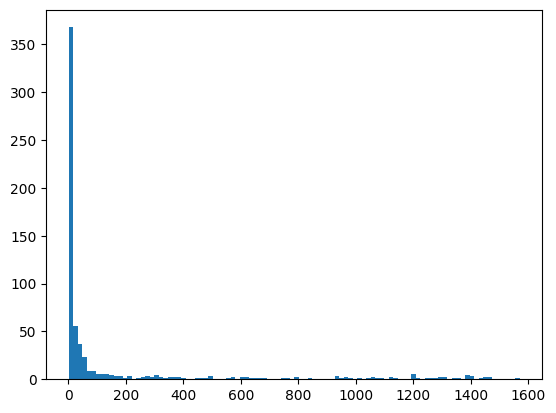

In [238]:
# Now we need to select the coordinates based on the frequency of the coordinates
# Lets check the distribution of the frequency of the coordinates
# We will create a histogram of the frequency of the coordinates

plt.hist(oceanCoords['size'], bins=100)
plt.show()

In [239]:
oceanCoords['size'].describe()

count     621.000000
mean      138.518519
std       330.116170
min         1.000000
25%         2.000000
50%         8.000000
75%        52.000000
max      1569.000000
Name: size, dtype: float64

In [240]:
# Lets see the location of the coordinates with less than 100 frequency
low_freq_coords = oceanCoords[oceanCoords['size'] < 100]
low_freq_coords

,Lat (lokasjon),Lon (lokasjon),size,Ocean,marker_size
152,60.25,0.5,98,1.0,5.556760
153,71.75,18.0,93,1.0,5.528061
154,73.50,31.0,91,1.0,5.516582
155,72.50,29.0,90,1.0,5.510842
156,75.50,16.0,89,1.0,5.505102
...,...,...,...,...,...
666,56.75,-14.5,1,1.0,5.000000
667,56.75,-0.5,1,1.0,5.000000
668,56.75,1.5,1,1.0,5.000000
670,78.25,14.0,1,1.0,5.000000


In [241]:
fig = go.Figure(go.Scattermapbox(lat=low_freq_coords['Lat (lokasjon)'], lon=low_freq_coords['Lon (lokasjon)'], mode='markers', 
                                 hovertext=low_freq_coords['size'], marker=go.scattermapbox.Marker(size=low_freq_coords['marker_size'], color=low_freq_coords['size'], coloraxis='coloraxis')))
                                 #marker=dict(size=5, color='red', opacity=0.5)))

fig.update_mapboxes(style='open-street-map', center=dict(lat=70, lon=7), zoom=2.5)
fig.update_layout(
    height=1000,
    hovermode='closest', showlegend=False)
fig.update_traces(marker_sizemin=2)
fig.show()

In [242]:
# Lets see how often these low frequency coordinates appear in the total dataset
low_freq_coords['size'].sum()

7085

In [243]:
high_freq_coords = oceanCoords[oceanCoords['size'] >= 100]
print(high_freq_coords['size'].sum())
print(high_freq_coords['size'].sum() / oceanCoords['size'].sum())
high_freq_coords

78935
0.9176354336200884


,Lat (lokasjon),Lon (lokasjon),size,Ocean,marker_size
0,69.25000,14.50000,1569,1.0,14.000000
1,70.73675,21.54827,1473,1.0,13.448980
2,58.25000,5.50000,1470,1.0,13.431760
3,69.74206,17.49100,1457,1.0,13.357143
4,66.25000,11.50000,1448,1.0,13.305485
...,...,...,...,...,...
147,71.25000,22.50000,109,1.0,5.619898
148,68.25000,11.50000,106,1.0,5.602679
149,60.25000,2.50000,106,1.0,5.602679
150,61.25000,2.50000,104,1.0,5.591199


In [244]:
fig = go.Figure(go.Scattermapbox(lat=high_freq_coords['Lat (lokasjon)'], lon=high_freq_coords['Lon (lokasjon)'], mode='markers', 
                                 hovertext=high_freq_coords['size'], marker=go.scattermapbox.Marker(size=high_freq_coords['marker_size'], color=high_freq_coords['size'], coloraxis='coloraxis')))
                                 #marker=dict(size=5, color='red', opacity=0.5)))

fig.update_mapboxes(style='open-street-map', center=dict(lat=70, lon=7), zoom=2.5)
fig.update_layout(
    height=1000,
    hovermode='closest', showlegend=False)
fig.update_traces(marker_sizemin=2)
fig.show()

In [245]:
# The matrices we will be using will have a resolution of 1 pixel per 0.25 degrees, to match the salinity and SST data. We preferably want the matrices to be square, for simplicity. Seeing as simply selecting the coordinates with higher than 50 frequency already shaves off a lot of coordinates and focuses the area, we can probably do with relatively small matrices spanning Norway. We must decide on a bounding box for the matrices. Lets check the pixel distance between the coordinates with frequency higher than 50.

In [246]:
def bounding_box(frequency: int = 50):
    high_freq_coords = oceanCoords[oceanCoords['size'] >= frequency]
    lat_min = high_freq_coords['Lat (lokasjon)'].min()
    lat_max = high_freq_coords['Lat (lokasjon)'].max()
    lon_min = high_freq_coords['Lon (lokasjon)'].min()
    lon_max = high_freq_coords['Lon (lokasjon)'].max()
    
    # Round the coordinates to the nearest 0.25 degrees
    lat_min = np.floor(lat_min * 4) / 4
    lat_max = np.ceil(lat_max * 4) / 4
    lon_min = np.floor(lon_min * 4) / 4
    lon_max = np.ceil(lon_max * 4) / 4
    
    # Get distance in pixels
    d_lat = (lat_max - lat_min) * 4
    d_lon = (lon_max - lon_min) * 4
    
    return d_lat, d_lon

In [247]:
bounding_box(100)

(74.0, 122.0)

In [248]:
# Okay with a frequency of >= 1100, our boundary box is close to 128x128 pixels, while keeping 91% of the data. Lets go with this size

In [249]:
# Lets get the center of the bounding box

lat_center = (high_freq_coords['Lat (lokasjon)'].max() + high_freq_coords['Lat (lokasjon)'].min()) / 2
lon_center = (high_freq_coords['Lon (lokasjon)'].max() + high_freq_coords['Lon (lokasjon)'].min()) / 2
lat_center, lon_center

(66.37444500000001, 17.75)

In [250]:
print(np.median([high_freq_coords['Lat (lokasjon)'].max(), high_freq_coords['Lat (lokasjon)'].min()]))
np.median([high_freq_coords['Lon (lokasjon)'].max(), high_freq_coords['Lon (lokasjon)'].min()])

66.37444500000001


17.75

In [251]:
# Now we can create the bounding box using the center and the size in pixels of 128x128

lat_min = lat_center - 64 / 4
lat_max = lat_center + 64 / 4 - 0.25
lon_min = lon_center - 64 / 4
lon_max = lon_center + 64 / 4 - 0.25
lat_min, lat_max, lon_min, lon_max

(50.37444500000001, 82.12444500000001, 1.75, 33.5)

In [252]:
# Lets print the bounding box on the map
fig = go.Figure(go.Scattermapbox(lat=[lat_min, lat_min, lat_max, lat_max], lon=[lon_min, lon_max, lon_min, lon_max],
                                                      mode='markers', marker=dict(size=5, color='red', opacity=0.5)))

fig.update_mapboxes(style='open-street-map', center=dict(lat=lat_center, lon=lon_center), zoom=6)
fig.update_layout(
    height=1000,
    hovermode='closest', showlegend=False)
fig.show()

In [253]:
# Now we need to select the coordinates within the bounding box. First we must round the coordinates to the nearest 0.25 degrees such that they fit the 128x128 resolution of the matrices

# We will round the coordinates down to the nearest 0.25 degrees, which results in 128 steps in each direction
print((np.floor(lat_max * 4) / 4 - np.floor(lat_min * 4) / 4) / 0.25)
print((np.floor(lon_max * 4) / 4 - np.floor(lon_min * 4) / 4) / 0.25)

127.0
127.0


In [254]:
# So our boundaries are

lat_min = np.floor(lat_min * 4) / 4
lat_max = np.floor(lat_max * 4) / 4
lon_min = np.floor(lon_min * 4) / 4
lon_max = np.floor(lon_max * 4) / 4

In [255]:
lat_min, lat_max, lon_min, lon_max

(50.25, 82.0, 1.75, 33.5)

In [256]:
# Now we select the coordinates within the bounding box

selected_coords = oceanCoords[(oceanCoords['Lat (lokasjon)'] >= lat_min) & (oceanCoords['Lat (lokasjon)'] <= lat_max) & (oceanCoords['Lon (lokasjon)'] >= lon_min) & (oceanCoords['Lon (lokasjon)'] <= lon_max)]

In [257]:
selected_coords

,Lat (lokasjon),Lon (lokasjon),size,Ocean,marker_size
0,69.25000,14.50000,1569,1.0,14.000000
1,70.73675,21.54827,1473,1.0,13.448980
2,58.25000,5.50000,1470,1.0,13.431760
3,69.74206,17.49100,1457,1.0,13.357143
4,66.25000,11.50000,1448,1.0,13.305485
...,...,...,...,...,...
648,77.02027,9.94820,1,1.0,5.000000
649,77.25000,4.00000,1,1.0,5.000000
661,53.75000,3.50000,1,1.0,5.000000
664,56.25000,7.50000,1,1.0,5.000000


In [258]:
# Let's save the bounding box coordinates
df = pd.DataFrame(data={'Lat (lokasjon)': [lat_min, lat_max, lat_max, lat_min], 'Lon (lokasjon)': [lon_min, lon_min, lon_max, lon_max]})
df.to_csv(path + '/train/' + 'bounding_box_coords.csv', index=False)

In [259]:
# Now we can select the coordinates within the bounding box for each year
for i in tqdm(range(2015,2021)):
    data = pd.read_csv(path + '/train/dataframes/' + 'fangstdata_' + str(i) + '_cod.csv', usecols=['Lat (lokasjon)', 'Lon (lokasjon)', 'Produktvekt', 'Siste fangstdato'])
    data = data[(data['Lat (lokasjon)'] >= lat_min) & (data['Lat (lokasjon)'] <= lat_max) & (data['Lon (lokasjon)'] >= lon_min) & (data['Lon (lokasjon)'] <= lon_max)]
    data.to_csv(path + '/train/dataframes_inside_box/' + 'fangstdata_' + str(i) + '_cod.csv', index=False)

100%|██████████| 6/6 [00:00<00:00, 30.60it/s]


In [260]:
# Now we combine the data into one file
data = pd.DataFrame()
for i in tqdm(range(2015, 2021)):
    data = pd.concat([data, pd.read_csv(path + '/train/dataframes_inside_box/' + 'fangstdata_' + str(i) + '_cod.csv')])
    data['Siste fangstdato'] = pd.to_datetime(data['Siste fangstdato'], format='%Y-%m-%d')
    data.sort_values(by='Siste fangstdato', inplace=True)
data.to_csv(path + '/train/' + 'fangstdata_all_years_cod.csv', index=False)

100%|██████████| 6/6 [00:00<00:00,  7.62it/s]


In [261]:
# Now we create a matrix containing matrix coordinate maps with the product weight as values
# NOTE: we do not consider the case where lon/lat is negative because our bounding box has all positive coordinates
cod_training_data = torch.zeros((len(train_data), 128, 128))
data = pd.read_csv(path + '/train/' + 'fangstdata_all_years_cod.csv')
for index, row in tqdm(data.iterrows(), total=data.shape[0], position=0, leave=True):
    lat = np.floor(row['Lat (lokasjon)'])
    lon = np.floor(row['Lon (lokasjon)'])
    lat_index = int((lat - lat_min) * 4)
    lon_index = int((lon - lon_min) * 4)
    cod_training_data[train_data.get_loc(row['Siste fangstdato']), lat_index, lon_index] = row['Produktvekt']

100%|██████████| 110320/110320 [00:09<00:00, 12141.13it/s]


In [262]:
pd.Series(train_data, name='Siste fangstdato').to_csv(path + '/train/' + 'train_data.csv', index=False)
pd.Series(val_data, name='Siste fangstdato').to_csv(path + '/val/' + 'val_data.csv', index=False)
pd.Series(test_data, name='Siste fangstdato').to_csv(path + '/test/' + 'test_data.csv', index=False)

In [263]:
# Now we can save the training data
torch.save(cod_training_data, path + '/train/' + 'cod_train_data.pt')

In [ ]:
# Now we can do the same for the validation and test data. First we select the dates within the validation and test data and fill in the missing coordinates with the coordinates of the hovedområde found in the training data

In [264]:
val_data.min(), val_data.max()

(Timestamp('2020-01-13 00:00:00'), Timestamp('2021-01-21 00:00:00'))

In [265]:
for i in tqdm(range(2020, 2022)):
    data = pd.read_csv(path + '/Catch Notes Datasets/' + 'fangstdata_' + str(i) + '.csv', delimiter=';', decimal=',', encoding='utf8', usecols=relevant_columns)
    data = data[data['Art - gruppe'] == 'Torsk']
    data['Siste fangstdato'] = pd.to_datetime(data['Siste fangstdato'], format='%d.%m.%Y')
    data = data[data['Siste fangstdato'] >= val_data.min()]
    data = data[data['Siste fangstdato'] <= val_data.max()]
    for index, row in data.iterrows():
        if pd.isnull(row['Lat (lokasjon)']) or pd.isnull(row['Lon (lokasjon)']):
            hovedomrade = row['Hovedområde']
            if hovedomrade not in unique_hovedomrade['Hovedområde'].values:
                continue
            lat = unique_hovedomrade[unique_hovedomrade['Hovedområde'] == hovedomrade]['Lat (hovedområde)'].values[0]
            lon = unique_hovedomrade[unique_hovedomrade['Hovedområde'] == hovedomrade]['Lon (hovedområde)'].values[0]
            data.at[index, 'Lat (lokasjon)'] = lat
            data.at[index, 'Lon (lokasjon)'] = lon
    data.dropna(inplace=True)
    data = data[['Produktvekt', 'Siste fangstdato', 'Lon (lokasjon)', 'Lat (lokasjon)']]
    data = data.groupby(['Siste fangstdato', 'Lon (lokasjon)', 'Lat (lokasjon)'], as_index=False).agg({'Produktvekt': 'sum'})
    data.sort_values(by='Siste fangstdato', inplace=True)
    data.to_csv(path + '/val/dataframes/' + 'fangstdata_' + str(i) + '_cod.csv', index=False)

100%|██████████| 2/2 [00:18<00:00,  9.03s/it]


In [266]:
# Now we can select the coordinates within the bounding box for each year
for i in tqdm(range(2020, 2022)):
    data = pd.read_csv(path + '/val/dataframes/' + 'fangstdata_' + str(i) + '_cod.csv', usecols=['Lat (lokasjon)', 'Lon (lokasjon)', 'Produktvekt', 'Siste fangstdato'])
    data = data[(data['Lat (lokasjon)'] >= lat_min) & (data['Lat (lokasjon)'] <= lat_max) & (data['Lon (lokasjon)'] >= lon_min) & (data['Lon (lokasjon)'] <= lon_max)]
    data.to_csv(path + '/val/dataframes_inside_box/' + 'fangstdata_' + str(i) + '_cod.csv', index=False)

100%|██████████| 2/2 [00:00<00:00, 35.04it/s]


In [267]:
# Now we combine the data into one file
data = pd.DataFrame()
for i in tqdm(range(2020, 2022)):
    data = pd.concat([data, pd.read_csv(path + '/val/dataframes_inside_box/' + 'fangstdata_' + str(i) + '_cod.csv')])
    data['Siste fangstdato'] = pd.to_datetime(data['Siste fangstdato'], format='%Y-%m-%d')
    data.sort_values(by='Siste fangstdato', inplace=True)
data.to_csv(path + '/val/' + 'fangstdata_all_years_cod.csv', index=False)

100%|██████████| 2/2 [00:00<00:00, 64.28it/s]


In [268]:
# Now we create a matrix containing matrix coordinate maps with the product weight as values
cod_validation_data = torch.zeros((len(val_data), 128, 128))
data = pd.read_csv(path + '/val/' + 'fangstdata_all_years_cod.csv')
for index, row in tqdm(data.iterrows(), total=data.shape[0], position=0, leave=True):
    lat = np.floor(row['Lat (lokasjon)'])
    lon = np.floor(row['Lon (lokasjon)'])
    lat_index = int((lat - lat_min) * 4)
    lon_index = int((lon - lon_min) * 4)
    cod_validation_data[val_data.get_loc(row['Siste fangstdato']), lat_index, lon_index] = row['Produktvekt']

100%|██████████| 23779/23779 [00:01<00:00, 12724.31it/s]


In [269]:
# Now we can save the validation data
torch.save(cod_validation_data, path + '/val/' + 'cod_val_data.pt')

In [ ]:
# Now we do the same for the test data

In [270]:
test_data.min(), test_data.max()

(Timestamp('2021-01-22 00:00:00'), Timestamp('2022-01-31 00:00:00'))

In [271]:
for i in tqdm(range(2021, 2023)):
    data = pd.read_csv(path + '/Catch Notes Datasets/' + 'fangstdata_' + str(i) + '.csv', delimiter=';', decimal=',', encoding='utf8', usecols=relevant_columns)
    data = data[data['Art - gruppe'] == 'Torsk']
    data['Siste fangstdato'] = pd.to_datetime(data['Siste fangstdato'], format='%d.%m.%Y')
    data = data[data['Siste fangstdato'] >= test_data.min()]
    data = data[data['Siste fangstdato'] <= test_data.max()]
    for index, row in data.iterrows():
        if pd.isnull(row['Lat (lokasjon)']) or pd.isnull(row['Lon (lokasjon)']):
            hovedomrade = row['Hovedområde']
            if hovedomrade not in unique_hovedomrade['Hovedområde'].values:
                continue
            lat = unique_hovedomrade[unique_hovedomrade['Hovedområde'] == hovedomrade]['Lat (hovedområde)'].values[0]
            lon = unique_hovedomrade[unique_hovedomrade['Hovedområde'] == hovedomrade]['Lon (hovedområde)'].values[0]
            data.at[index, 'Lat (lokasjon)'] = lat
            data.at[index, 'Lon (lokasjon)'] = lon
    data.dropna(inplace=True)
    data = data[['Produktvekt', 'Siste fangstdato', 'Lon (lokasjon)', 'Lat (lokasjon)']]
    data = data.groupby(['Siste fangstdato', 'Lon (lokasjon)', 'Lat (lokasjon)'], as_index=False).agg({'Produktvekt': 'sum'})
    data.sort_values(by='Siste fangstdato', inplace=True)
    data.to_csv(path + '/test/dataframes/' + 'fangstdata_' + str(i) + '_cod.csv', index=False)

100%|██████████| 2/2 [00:17<00:00,  8.80s/it]


In [272]:
# Now we can select the coordinates within the bounding box for each year
for i in tqdm(range(2021, 2023)):
    data = pd.read_csv(path + '/test/dataframes/' + 'fangstdata_' + str(i) + '_cod.csv', usecols=['Lat (lokasjon)', 'Lon (lokasjon)', 'Produktvekt', 'Siste fangstdato'])
    data = data[(data['Lat (lokasjon)'] >= lat_min) & (data['Lat (lokasjon)'] <= lat_max) & (data['Lon (lokasjon)'] >= lon_min) & (data['Lon (lokasjon)'] <= lon_max)]
    data.to_csv(path + '/test/dataframes_inside_box/' + 'fangstdata_' + str(i) + '_cod.csv', index=False)

100%|██████████| 2/2 [00:00<00:00, 28.78it/s]


In [273]:
# Now we combine the data into one file
data = pd.DataFrame()
for i in tqdm(range(2021, 2023)):
    data = pd.concat([data, pd.read_csv(path + '/test/dataframes_inside_box/' + 'fangstdata_' + str(i) + '_cod.csv')])
    data['Siste fangstdato'] = pd.to_datetime(data['Siste fangstdato'], format='%Y-%m-%d')
    data.sort_values(by='Siste fangstdato', inplace=True)
data.to_csv(path + '/test/' + 'fangstdata_all_years_cod.csv', index=False)

100%|██████████| 2/2 [00:00<00:00, 52.11it/s]


In [274]:
# Now we create a matrix containing matrix coordinate maps with the product weight as values
cod_test_data = torch.zeros((len(test_data), 128, 128))
data = pd.read_csv(path + '/test/' + 'fangstdata_all_years_cod.csv')
for index, row in tqdm(data.iterrows(), total=data.shape[0], position=0, leave=True):
    lat = np.floor(row['Lat (lokasjon)'])
    lon = np.floor(row['Lon (lokasjon)'])
    lat_index = int((lat - lat_min) * 4)
    lon_index = int((lon - lon_min) * 4)
    cod_validation_data[test_data.get_loc(row['Siste fangstdato']), lat_index, lon_index] = row['Produktvekt']

100%|██████████| 24602/24602 [00:02<00:00, 12282.51it/s]


In [276]:
# Now we can save the test data
torch.save(cod_test_data, path + '/test/' + 'cod_test_data.pt')

In [ ]:
# Now for the salinity and SST data, we need to select the coordinates within the bounding box
# First we will do the SST data for the training dataset. We first need a boolean mask for the land and ocean coordinates, to be used for filling in missing values

In [277]:
lats = np.arange(lat_min, lat_max + 0.25, 0.25)
lons = np.arange(lon_min, lon_max + 0.25, 0.25)
lats.shape, lons.shape

((128,), (128,))

In [278]:
bm_low_res = Basemap()

In [279]:
mask = np.full((128, 128), np.nan)
i = 0
for lat in tqdm(lats, position=0, leave=True):
    j = 0
    for lon in lons:
        x, y = bm_low_res(lon, lat)
        if not bm_low_res.is_land(x, y):
            mask[i, j] = 1
        j += 1
    i += 1
mask

100%|██████████| 128/128 [00:06<00:00, 18.75it/s]


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

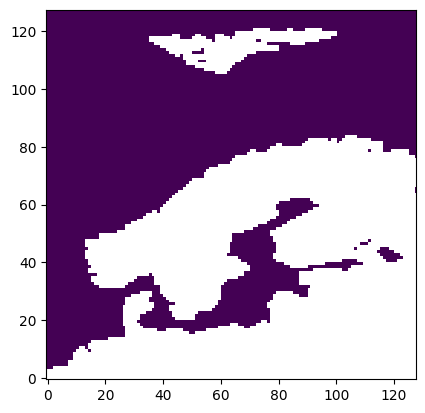

In [280]:
plt.imshow(mask, origin='lower')

In [281]:
boolean_mask = ~np.isnan(mask)
boolean_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [288]:
sst_training_data = torch.zeros((len(train_data), 128, 128))
for i in tqdm(range(2015, 2021)):
    if os.path.isfile(path + '/sst_data-002/sst_data/sst.day.mean.' + str(i) + '.nc'):
        data = xr.open_dataset(path + '/sst_data-002/sst_data/' + 'sst.day.mean.' + str(i) + '.nc')
        data.coords['lon'] = (data.coords['lon'] + 180) % 360 - 180
        data = data.sortby(data.lon)
        data = data.sst.sel(lat=slice(lat_min, lat_max + 0.25), lon=slice(lon_min, lon_max + 0.25))
        year_dates = train_data[(train_data >= pd.to_datetime(str(i) + '-01-01')) & (train_data <= pd.to_datetime(str(i) + '-12-31'))]
        for date in year_dates:
            date_data = data.sel(time=date)
            nan_values = date_data.isnull().to_numpy()
            missing_ocean_values = np.logical_and(nan_values, boolean_mask)
            for lat_index, lon_index in zip(*np.where(missing_ocean_values)):
                lat = lats[lat_index]
                lon = lons[lon_index]
                missing_values = date_data.sel(lat=slice(lat - 3, lat + 3), lon=slice(lon - 3, lon + 3)).values
                missing_values = missing_values[~np.isnan(missing_values)]
                if missing_values.size > 0:
                    date_data[lat_index, lon_index] = missing_values.mean()
            sst_training_data[train_data.get_loc(date)] = torch.tensor(date_data.to_numpy())

100%|██████████| 6/6 [05:36<00:00, 56.06s/it]


In [289]:
# Now we can save the training data
torch.save(sst_training_data, path + '/train/' + 'sst_train_data.pt')

In [290]:
del sst_training_data

In [291]:
# Now we do the same for the validation data
sst_validation_data = torch.zeros((len(val_data), 128, 128))
for i in tqdm(range(2020, 2022)):
    if os.path.isfile(path + '/sst_data-002/sst_data/sst.day.mean.' + str(i) + '.nc'):
        data = xr.open_dataset(path + '/sst_data-002/sst_data/' + 'sst.day.mean.' + str(i) + '.nc')
        data.coords['lon'] = (data.coords['lon'] + 180) % 360 - 180
        data = data.sortby(data.lon)
        data = data.sst.sel(lat=slice(lat_min, lat_max + 0.25), lon=slice(lon_min, lon_max + 0.25))
        year_dates = val_data[(val_data >= pd.to_datetime(str(i) + '-01-01')) & (val_data <= pd.to_datetime(str(i) + '-12-31'))]
        for date in year_dates:
            date_data = data.sel(time=date)
            nan_values = date_data.isnull().to_numpy()
            missing_ocean_values = np.logical_and(nan_values, boolean_mask)
            for lat_index, lon_index in zip(*np.where(missing_ocean_values)):
                lat = lats[lat_index]
                lon = lons[lon_index]
                missing_values = date_data.sel(lat=slice(lat - 3, lat + 3), lon=slice(lon - 3, lon + 3)).values
                missing_values = missing_values[~np.isnan(missing_values)]
                if missing_values.size > 0:
                    date_data[lat_index, lon_index] = missing_values.mean()
            sst_validation_data[val_data.get_loc(date)] = torch.tensor(date_data.to_numpy())

100%|██████████| 2/2 [01:16<00:00, 38.17s/it]


In [292]:
# Now we can save the validation data
torch.save(sst_validation_data, path + '/val/' + 'sst_val_data.pt')

In [293]:
del sst_validation_data

In [294]:
# Now we do the same for the test data
sst_test_data = torch.zeros((len(test_data), 128, 128))
for i in tqdm(range(2021, 2023)):
    if os.path.isfile(path + '/sst_data-002/sst_data/sst.day.mean.' + str(i) + '.nc'):
        data = xr.open_dataset(path + '/sst_data-002/sst_data/' + 'sst.day.mean.' + str(i) + '.nc')
        data.coords['lon'] = (data.coords['lon'] + 180) % 360 - 180
        data = data.sortby(data.lon)
        data = data.sst.sel(lat=slice(lat_min, lat_max + 0.25), lon=slice(lon_min, lon_max + 0.25))
        year_dates = test_data[(test_data >= pd.to_datetime(str(i) + '-01-01')) & (test_data <= pd.to_datetime(str(i) + '-12-31'))]
        for date in year_dates:
            date_data = data.sel(time=date)
            nan_values = date_data.isnull().to_numpy()
            missing_ocean_values = np.logical_and(nan_values, boolean_mask)
            for lat_index, lon_index in zip(*np.where(missing_ocean_values)):
                lat = lats[lat_index]
                lon = lons[lon_index]
                missing_values = date_data.sel(lat=slice(lat - 3, lat + 3), lon=slice(lon - 3, lon + 3)).values
                missing_values = missing_values[~np.isnan(missing_values)]
                if missing_values.size > 0:
                    date_data[lat_index, lon_index] = missing_values.mean()
            sst_test_data[test_data.get_loc(date)] = torch.tensor(date_data.to_numpy())

100%|██████████| 2/2 [01:11<00:00, 35.62s/it]


In [295]:
# Now we can save the test data
torch.save(sst_test_data, path + '/test/' + 'sst_test_data.pt')

In [296]:
del sst_test_data

In [ ]:
# Now for the salinity data
# Since the salinity data only exists from April 2015 to January 2022, we have to take a different approach. Also, since the salinity data has much more missing values, the best strategy to fill them is to use the mean of the entire bounded region, which is not optimal at all, but the surrounding values approach taken for the SST data simply does not fill in that many value. In case anyone other than me is reading this in the future, the problem concretely is that country borders are not very well defined in the dataset and most of the arctic ocean region is just not measured. My other notebook 'Data_selection.ipynb' contains a plotted graph of the salinity data, showing the extent of the missing values. I have tried the SST approach previously, only to keep ending up with NANs. So yeah, that's why I'm doing this.
# So the approach is this: Get the salinity maps for the months in the dataset, fill in missing values with the bounded mean, then, since the month July 2019 just is not present in the dataset, use the means of June and August 2019 for this month.

In [297]:
# Lets just make a collective matrix for the salinity data
salinity_dataset = torch.zeros((82, 128, 128)) # 82 months from April 2015 to January 2022
for i in tqdm(range(2015, 2023)):
    for j in range(1, 13):
        if os.path.isfile(path + '/Salinity Data - Monthly Average/salinity_data/RSS_smap_SSS_L3_monthly_' + str(i) + '_' + str(j).zfill(2) + '_FNL_v04.0.nc'):
            salinity = xr.open_dataset(path + '/Salinity Data - Monthly Average/salinity_data/RSS_smap_SSS_L3_monthly_' + str(i) + '_' + str(j).zfill(2) + '_FNL_v04.0.nc')
            salinity.coords['lon'] = (salinity.coords['lon'] + 180) % 360 - 180
            salinity = salinity.sortby(salinity.lon)
            salinity = salinity.sss_smap.sel(lat=slice(lat_min, lat_max + 0.25), lon=slice(lon_min, lon_max + 0.25))
            mean_value = salinity.values[~np.isnan(salinity)].mean()
            nan_values = salinity.isnull().to_numpy()
            missing_ocean_values = np.logical_and(nan_values, boolean_mask)
            for lat_index, lon_index in zip(*np.where(missing_ocean_values)):
                salinity[lat_index, lon_index] = mean_value
            salinity_dataset[(i - 2015) * 12 + j - 4] = torch.tensor(salinity.to_numpy())
            

100%|██████████| 8/8 [00:51<00:00,  6.49s/it]


In [298]:
# Now to fill in the one missing month, july 2019. Index should be 3 + 12 * 4 = 51
salinity_dataset[51] = torch.nanmean(torch.stack([salinity_dataset[50], salinity_dataset[52]]), dim=0)

In [299]:
# Now we fill each day with its month mean salinity level
salinity_training_data = torch.zeros((len(train_data), 128, 128))
for day in tqdm(train_data, position=0, leave=True):
    salinity_training_data[train_data.get_loc(day)] = salinity_dataset[(day.year - 2015) * 12 + day.month - 4]

100%|██████████| 1748/1748 [00:00<00:00, 66005.05it/s]


In [302]:
# Now we can save the training data
torch.save(salinity_training_data, path + '/train/' + 'salinity_train_data.pt')

In [303]:
del salinity_training_data

In [304]:
# Now we do the same for the validation data
salinity_validation_data = torch.zeros((len(val_data), 128, 128))
for day in tqdm(val_data, position=0, leave=True):
    salinity_validation_data[val_data.get_loc(day)] = salinity_dataset[(day.year - 2015) * 12 + day.month - 4]

100%|██████████| 375/375 [00:00<00:00, 64857.70it/s]


In [305]:
# Now we can save the validation data
torch.save(salinity_validation_data, path + '/val/' + 'salinity_val_data.pt')

In [306]:
del salinity_validation_data

In [307]:
# Now we do the same for the test data
salinity_test_data = torch.zeros((len(test_data), 128, 128))
for day in tqdm(test_data, position=0, leave=True):
    salinity_test_data[test_data.get_loc(day)] = salinity_dataset[(day.year - 2015) * 12 + day.month - 4]

100%|██████████| 375/375 [00:00<00:00, 70349.05it/s]


In [310]:
# Now we can save the test data
torch.save(salinity_test_data, path + '/test/' + 'salinity_test_data.pt')